In [1]:
# This project shows how to develop a image caption generator using flickr dataset in python.
# The project uses keras & tensorflow framework for the implementation. 
# It uses both image features and text features in the project for building the model.
# This will give a better understanding of how we can leverage the model architecture of different domains for a specific application. 

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input   # vgg16 used for extractng features from image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = 'storage'
WORKING_DIR = 'working'

In [4]:
# Extract image features

In [5]:
## load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# features = {}
# directory = os.path.join(BASE_DIR,'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the mage from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224,224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image,verbose = 0)
#     # get image id
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [7]:
# # Store features in pickle
# pickle.dump(features,open(os.path.join(WORKING_DIR,'features,pkl'),'wb'))

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features = pickle.load(f)

In [9]:
len(features)

8091

In [10]:
# load the captions data

with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# captions_doc

In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id,caption = tokens[0], tokens[1:]
    # remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

In [14]:
# Preprocess Text Data

In [15]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special characters
            caption = caption.replace('[^A-Za-z]','')
            # delete additional spaces
            caption = caption.replace('\s+',' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40455

In [21]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8485

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [25]:
# Train Test Split

In [26]:
image_ids = list(mapping.keys())
split = int(len(image_ids)* 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [27]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys,mapping, features, tokenizer,max_length,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i],seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1,X2], y
                X1, X2, y = list(), list(), list()
                n = 0
                

In [28]:
# Model creation

In [29]:
# Encoder Model
# image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)
# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [30]:
# # train the model
# epochs = 50
# batch_size = 64
# steps = len(train) // batch_size 

# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
#     # fit for one epoch
#     model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [31]:
# # save the model
# model.save(WORKING_DIR+'/best_model.h5')

In [32]:
model=tf.keras.models.load_model(WORKING_DIR+'/best_model.h5')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 35, 256)      2172160     ['input_13[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 4096)         0           ['input_12[0][0]']               
                                                                                            

In [33]:
# Generate captions for the image

In [34]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
      # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence],max_length)
        # predict next word
        yhat = model.predict([image, sequence],verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat,tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [36]:
type(tokenizer)

keras.preprocessing.text.Tokenizer

In [37]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(),list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    actual_caption = [caption.split() for caption in captions]
    actual.append(actual_caption)
    predicted.append(y_pred.split())
    
# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.543123
BLEU-1: 0.322041


In [38]:
# Visualize the results

In [39]:
from PIL import Image
import  matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #     image_name = "1007320043_627395c3d8.jpg"
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print('----------------------Actual------------------------')
    for caption in captions:
        print(caption)
    # predict caption
    y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
    print('-------------------Predicted------------------------')
    print(y_pred)
    plt.imshow(image)

----------------------Actual------------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
-------------------Predicted------------------------
startseq boston terrier is jumping over an obstacle endseq


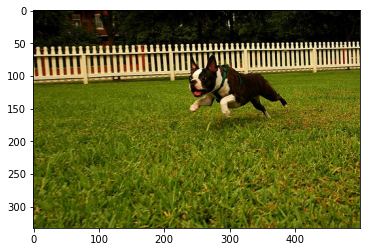

In [40]:
generate_caption("1009434119_febe49276a.jpg")

----------------------Actual------------------------
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
-------------------Predicted------------------------
startseq two children are rowing down blue kayak endseq


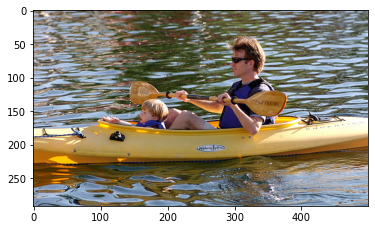

In [41]:
generate_caption("1028205764_7e8df9a2ea.jpg")

----------------------Actual------------------------
startseq girl in pigtails splashes in the shallow water endseq
startseq girls plays in the surf endseq
startseq girl with pigtails is playing in the ocean by the beach endseq
startseq girl with pigtails plays in the water endseq
startseq young girl in pigtails plays in the water endseq
-------------------Predicted------------------------
startseq girl in pigtails plays in the ocean endseq


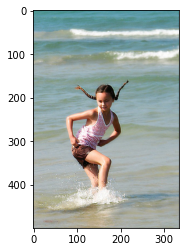

In [42]:
generate_caption("1053804096_ad278b25f1.jpg")